In [1]:
# Importing Libraries

import pandas as pd
import numpy as np

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2


In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# function to print the confusion matrix

def confusion_matrix(Y_true, Y_pred):
    
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

    
   # result = confusion_matrix(Y_true, Y_pred)

    #plt.figure(figsize=(10, 8))
   # sns.heatmap(result, 
    #            xticklabels= list(ACTIVITIES.values()), 
     #           yticklabels=list(ACTIVITIES.values()), 
      #          annot=True, fmt="d");
   # plt.title("Confusion matrix")
   # plt.ylabel('True label')
   # plt.xlabel('Predicted label')
    plt.show()  

<html><h1><p style="color:red">Loading Data / Making Data </p></h1></html>

In [3]:
# Data directory
DATADIR = 'UCI HAR Dataset/UCI HAR Dataset'

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [4]:
# function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI HAR Dataset/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [5]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI HAR Dataset/UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [6]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [9]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [10]:
#function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [11]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [12]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
n_classes

128
9
7352


6

<html><h1><p style="color:red">1. Defining the Architecture of 1-Layer of LSTM </p></h1></html>

In [13]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 15s 29ms/step - loss: 1.1698 - accuracy: 0.5063 - val_loss: 0.9967 - val_accuracy: 0.6121
Epoch 2/30
460/460 [==============================] - 13s 28ms/step - loss: 0.7328 - accuracy: 0.7116 - val_loss: 0.7551 - val_accuracy: 0.7156
Epoch 3/30
460/460 [==============================] - 13s 29ms/step - loss: 0.6135 - accuracy: 0.7782 - val_loss: 0.6477 - val_accuracy: 0.7723
Epoch 4/30
460/460 [==============================] - 14s 29ms/step - loss: 0.4331 - accuracy: 0.8570 - val_loss: 0.4823 - val_accuracy: 0.8544
Epoch 5/30
460/460 [==============================] - 14s 30ms/step - loss: 0.4046 - accuracy: 0.8664 - val_loss: 0.4773 - val_accuracy: 0.8605
Epoch 6/30
460/460 [==============================] - 14s 30ms/step - loss: 0.3442 - accuracy: 0.8810 - val_loss: 0.5517 - val_accuracy: 0.8235
Epoch 7/30
460/460 [==============================] - 14s 31ms/step - loss: 0.3210 - accuracy: 0.8889 - val_loss: 0.4908 - val_accuracy:

In [16]:
# Confusion Matrix
confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 3s 22ms/step


Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,0,373,113,1,0,4
STANDING,0,83,447,1,0,1
WALKING,0,0,1,450,38,7
WALKING_DOWNSTAIRS,0,0,0,4,414,2
WALKING_UPSTAIRS,0,0,0,6,6,459


In [17]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 2s 21ms/step - loss: 0.4104 - accuracy: 0.9094

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.4104450047016144, 0.9093993902206421]


<html><h3><p style="color:#008080">With a simple 1 layer architecture we got 90.09% accuracy and a loss of 0.47</p></h4></html>

<html><h1><p style="color:red">Defining the Architecture of 2-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [18]:
# Initializing parameters
n_epochs = 30
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

In [17]:
# Model execution
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(32))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Model Summary: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 32)           5376      
                                                                 
 batch_normalization (BatchN  (None, 128, 32)          128       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 128, 32)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                      

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 [==============================] - 33s 65ms/step - loss: 1.3459 - accuracy: 0.6586 - val_loss: 0.9858 - val_accuracy: 0.7733
Epoch 2/30
460/460 [==============================] - 29s 64ms/step - loss: 0.7542 - accuracy: 0.8120 - val_loss: 0.6196 - val_accuracy: 0.8432
Epoch 3/30
460/460 [==============================] - 29s 62ms/step - loss: 0.4987 - accuracy: 0.8834 - val_loss: 0.5289 - val_accuracy: 0.8544
Epoch 4/30
460/460 [==============================] - 29s 63ms/step - loss: 0.3275 - accuracy: 0.9161 - val_loss: 0.3547 - val_accuracy: 0.8918
Epoch 5/30
460/460 [==============================] - 29s 63ms/step - loss: 0.2555 - accuracy: 0.9287 - val_loss: 0.6088 - val_accuracy: 0.8300
Epoch 6/30
460/460 [==============================] - 29s 64ms/step - loss: 0.2448 - accuracy: 0.9244 - val_loss: 0.2757 - val_accuracy: 0.9080
Epoch 7/30
460/460 [==============================] - 29s 64ms/step - loss: 0.2158 - accuracy: 0.9279 - val_loss: 0.2255 - val_accuracy:

In [30]:
# Confusion Matrix
Confusion_matrix(Y_test, model.predict(X_test))


NameError: name 'Confusion_matrix' is not defined

In [31]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 2s 26ms/step - loss: 0.3259 - accuracy: 0.9192

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.325888991355896, 0.91923987865448]


<html><h1><p style="color:red">Defining the Architecture of 3-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [24]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential

In [26]:
model = Sequential()
model.add(LSTM(48, return_sequences=True, input_shape=(timesteps, input_dim)))  # returns a sequence of vectors of dimension 32
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(48, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.50))
model.add(LSTM(48))  # return a single vector of dimension 32
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128, 48)           11136     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 128, 48)           0         
                                                                 
 lstm_4 (LSTM)               (None, 128, 48)           18624     
                                                                 
 dropout_4 (Dropout)         (None, 128, 48)           0         
                                                                 
 lstm_5 (LSTM)               (None, 48)                18624     
                                                      

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 [==============================] - 47s 94ms/step - loss: 0.6395 - accuracy: 0.7564 - val_loss: 0.6912 - val_accuracy: 0.8042
Epoch 2/30
460/460 [==============================] - 45s 98ms/step - loss: 0.2854 - accuracy: 0.9106 - val_loss: 0.8241 - val_accuracy: 0.7146
Epoch 3/30
460/460 [==============================] - 49s 106ms/step - loss: 0.2032 - accuracy: 0.9304 - val_loss: 0.3022 - val_accuracy: 0.9030
Epoch 4/30
460/460 [==============================] - 48s 103ms/step - loss: 0.1835 - accuracy: 0.9343 - val_loss: 0.6815 - val_accuracy: 0.7462
Epoch 5/30
460/460 [==============================] - 48s 105ms/step - loss: 0.1918 - accuracy: 0.9313 - val_loss: 0.2751 - val_accuracy: 0.9220
Epoch 6/30
460/460 [==============================] - 48s 105ms/step - loss: 0.1843 - accuracy: 0.9316 - val_loss: 0.2861 - val_accuracy: 0.9243
Epoch 7/30
460/460 [==============================] - 50s 109ms/step - loss: 0.1527 - accuracy: 0.9442 - val_loss: 0.2774 - val_accu

In [36]:
import seaborn as sns
ax = plt.subplot()


#cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=0))
cm = confusion_matrix(Y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g',ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

NameError: name 'plt' is not defined

In [29]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 8s 83ms/step - loss: 0.2360 - accuracy: 0.9189

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.23595140874385834, 0.9189005494117737]


<html><h1><p style="color:red">Defining the Architecture of 4-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [37]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim)))  # returns a sequence of vectors of dimension 32
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.50))
model.add(LSTM(64, return_sequences=True))  # return a single vector of dimension 32
model.add(Dropout(0.50))
model.add(LSTM(64,))  # return a single vector of dimension 32
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128, 64)           18944     
                                                                 
 batch_normalization_2 (Batc  (None, 128, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128, 64)           33024     
                                                                 
 dropout_7 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_8 (LSTM)               (None, 128, 64)           33024     
                                                      

In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [40]:

# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 [==============================] - 70s 144ms/step - loss: 0.5121 - accuracy: 0.8141 - val_loss: 0.5225 - val_accuracy: 0.7421
Epoch 2/30
460/460 [==============================] - 92s 200ms/step - loss: 0.2694 - accuracy: 0.9027 - val_loss: 0.4167 - val_accuracy: 0.8588
Epoch 3/30
460/460 [==============================] - 77s 168ms/step - loss: 0.1913 - accuracy: 0.9287 - val_loss: 0.3333 - val_accuracy: 0.8894
Epoch 4/30
460/460 [==============================] - 81s 177ms/step - loss: 0.1589 - accuracy: 0.9362 - val_loss: 0.2628 - val_accuracy: 0.9053
Epoch 5/30
460/460 [==============================] - 82s 179ms/step - loss: 0.1951 - accuracy: 0.9294 - val_loss: 0.9740 - val_accuracy: 0.7377
Epoch 6/30
460/460 [==============================] - 76s 165ms/step - loss: 0.1643 - accuracy: 0.9348 - val_loss: 0.2575 - val_accuracy: 0.9135
Epoch 7/30
460/460 [==============================] - 76s 165ms/step - loss: 0.1446 - accuracy: 0.9429 - val_loss: 0.2774 - val_ac

93/93 [==============================] - 16s 139ms/step


Text(0.5, 1.0, 'Confusion Matrix')

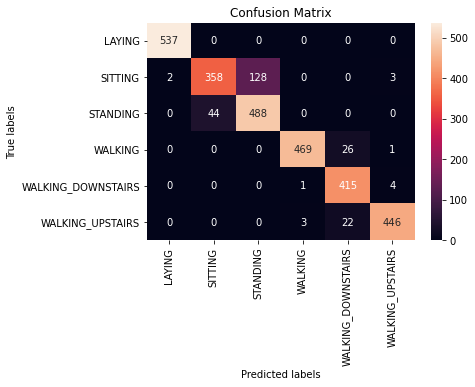

In [33]:
import seaborn as sns
ax = plt.subplot()


#cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=0))
cm = confusion_matrix(Y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g',ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [34]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 13s 140ms/step - loss: 0.3851 - accuracy: 0.9206

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.3851405680179596, 0.9205971956253052]


# <html><h1><p style="color:red">Defining the Architecture of 5-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [37]:
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(timesteps, input_dim)))  
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))  
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))  
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80,))  
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128, 80)           28800     
                                                                 
 batch_normalization_4 (Batc  (None, 128, 80)          320       
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 128, 80)           0         
                                                                 
 lstm_16 (LSTM)              (None, 128, 80)           51520     
                                                                 
 dropout_15 (Dropout)        (None, 128, 80)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128, 80)           51520     
                                                      

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [39]:

# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 [==============================] - 260s 531ms/step - loss: 0.5809 - accuracy: 0.7705 - val_loss: 1.4903 - val_accuracy: 0.5894
Epoch 2/30
460/460 [==============================] - 241s 525ms/step - loss: 0.3263 - accuracy: 0.8806 - val_loss: 0.3989 - val_accuracy: 0.8107
Epoch 3/30
460/460 [==============================] - 246s 535ms/step - loss: 0.2497 - accuracy: 0.9140 - val_loss: 0.5218 - val_accuracy: 0.8514
Epoch 4/30
460/460 [==============================] - 263s 573ms/step - loss: 0.1948 - accuracy: 0.9293 - val_loss: 0.4383 - val_accuracy: 0.8697
Epoch 5/30
460/460 [==============================] - 210s 457ms/step - loss: 0.2153 - accuracy: 0.9253 - val_loss: 0.4963 - val_accuracy: 0.8765
Epoch 6/30
460/460 [==============================] - 240s 522ms/step - loss: 0.1815 - accuracy: 0.9323 - val_loss: 0.3204 - val_accuracy: 0.9091
Epoch 7/30
460/460 [==============================] - 225s 490ms/step - loss: 0.1611 - accuracy: 0.9400 - val_loss: 0.4253 -

93/93 [==============================] - 27s 255ms/step


Text(0.5, 1.0, 'Confusion Matrix')

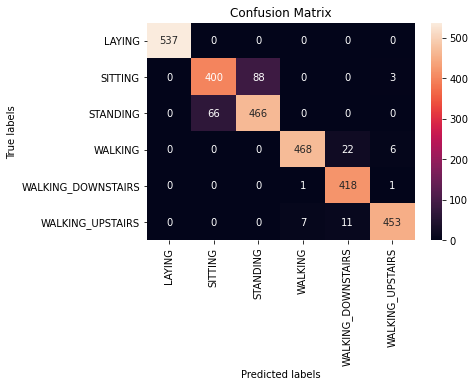

In [40]:
import seaborn as sns
ax = plt.subplot()


#cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=0))
cm = confusion_matrix(Y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g',ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [41]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 23s 247ms/step - loss: 0.2425 - accuracy: 0.9304

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.2424951195716858, 0.9304377436637878]
